In [1]:
!conda install --yes sklearn
!conda install --yes pandas
!conda install --yes nltk


PackagesNotFoundError: The following packages are not available from current channels:

  - sklearn

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\levil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\levil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\levil\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\levil\AppData\Roaming\nltk_data...


## Tokenization

In [4]:
df = pd.read_csv('spam_ham_dataset.csv')
df.drop(['Unnamed: 0'],axis=1, inplace=True)

df

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


In [5]:
import string

# remove punctuation
def remove_punkt(line):
    updated_str = ''
    for c in line:
        if c not in string.punctuation:
            updated_str += c
    return updated_str

df['cleand_text'] = df['text'].apply(remove_punkt)


In [6]:
import re
from nltk.tokenize import WhitespaceTokenizer

# Tokenize text, sentence => list of tokens
tokenizer_re = r"[^a-zA-Z0-9]"

def tokenize(doc: str) -> list():
    doc = re.sub(tokenizer_re, " ", doc.lower())
    return WhitespaceTokenizer().tokenize(doc)

df['tokenzied'] = df['cleand_text'].apply(tokenize)


In [7]:
stop_words = stopwords.words('english')

# remove stop words
def remove_stop_words(tokens):
    updated_list = []
    for token in tokens:
        if token not in stop_words:
            updated_list.append(token)
    return updated_list

df['cleaned_tokens'] = df['tokenzied'].apply(remove_stop_words)

In [8]:
# lemmatize words
lemmatizer = nltk.WordNetLemmatizer()

df['lem_text'] = df['cleaned_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [9]:
# join tokens back to sentence
df['final_text'] = df['lem_text'].apply(lambda tokens: ' '.join(tokens))

## EDA

In [10]:
import matplotlib.pyplot as plt
plt.style.use(style="seaborn")

df_eda = df.copy()

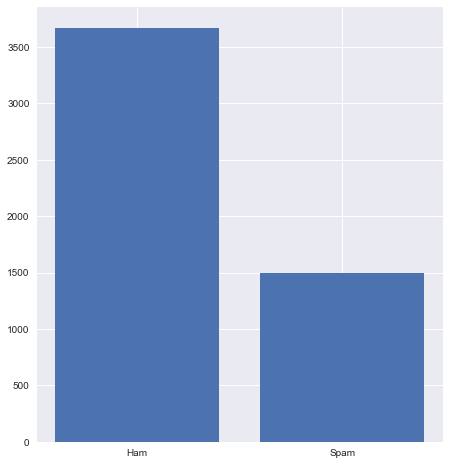

In [11]:
ham = df_eda[df_eda['label'] == 'ham'].shape[0]
spam = df_eda[df_eda['label'] == 'spam'].shape[0]

plt.figure(1,figsize=(16,8))
plt.subplot(1,2,1)
_ = plt.bar(['Ham', 'Spam'], [ham, spam])

In [12]:
from collections import Counter

# count ocuurences of every token in the dataframe
df_eda['count'] = df_eda['lem_text'].apply(Counter)

In [13]:
# sum the occurences of all tokens for every category: Span and Ham
count_words_ham = df_eda[df_eda['label']=='ham']['count'].sum()
count_words_spam = df_eda[df_eda['label']=='spam']['count'].sum()

In [14]:
# Convert the sum to dataframe
df_ham = pd.DataFrame.from_dict(count_words_ham, orient='index').sort_values(by=[0], ascending=False).reset_index()
df_spam = pd.DataFrame.from_dict(count_words_spam, orient='index').sort_values(by=[0], ascending=False).reset_index()


ham mails token distribution

In [15]:
df_ham

,index,0
0,ect,13897
1,hou,7281
2,enron,6555
3,subject,6405
4,2000,4308
...,...,...
18783,156387,1
18784,149421,1
18785,mecca,1
18786,huskers,1


spam mails token distribution

In [16]:
df_spam

,index,0
0,subject,1657
1,3,1239
2,com,992
3,http,984
4,company,918
...,...,...
36884,babylon,1
36885,squire,1
36886,batten,1
36887,kuwo,1


## Feature extraction

In [17]:
y=pd.DataFrame(df['label_num'])
x=pd.DataFrame(df[['lem_text', 'final_text']])

In [18]:
# split data to train and test. we want to learn the n-gram only on train and apply it on test
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2, random_state=42)

N-Gram features

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Take feature of n-gram of 1
model = CountVectorizer(ngram_range = (1, 1), max_features=5000)

matrix = model.fit_transform(x_train['final_text']).toarray()
temp_df = pd.DataFrame(data = matrix, columns = model.get_feature_names(),index=x_train.index)
x_train_ngram = pd.concat([x_train, temp_df],axis=1,sort=False)

matrix = model.transform(x_val['final_text']).toarray()
temp_df = pd.DataFrame(data = matrix, columns = model.get_feature_names(),index=x_val.index)
x_val_ngram = pd.concat([x_val, temp_df],axis=1,sort=False)


TFIDF Features

In [20]:
# Take feature of TF-IDF 
cv=CountVectorizer(max_features=5000)
temp_train=cv.fit_transform(x_train['final_text']).toarray()
temp_val=cv.transform(x_val['final_text']).toarray()


In [21]:
tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)


In [22]:
temp_train = pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val = pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train_tfidf = pd.concat([x_train,temp_train],axis=1,sort=False)
x_val_tfidf = pd.concat([x_val,temp_val],axis=1,sort=False)

x_train_tfidf.head()


,lem_text,final_text,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
5132,"[subject, april, activity, survey, starting, c...",subject april activity survey starting collect...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2067,"[subject, message, subject, hey, julie, turned...",subject message subject hey julie turned 18 hi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4716,"[subject, txu, fuel, sd, nomination, may, 2001...",subject txu fuel sd nomination may 2001 attach...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4710,"[subject, richardson, volume, nov, 99, dec, 99...",subject richardson volume nov 99 dec 99 meter ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.093117,0.0,0.0,0.0,0.0,0.0,0.0
2268,"[subject, new, era, online, medical, care, new...",subject new era online medical care new era on...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y_train=y_train.astype(int)
y_val=y_val.astype(int)


## Classifier
4 experiments:
1. N-Gram with Logistic Regression
2. N-Gram with Random Forest
3. TF-IDF with Logistic Regression
4. TF-IDF with Random Forest

In [24]:
from sklearn import metrics

# Calculate the benchmark for a classifier algorithm and dataset
# return classifier name, accuracy, precision_score, recall_score and f1_score
def benchmark(classifier_algorithm, X_train, y_train, X_test, y_test):
    classifier_algorithm.fit(X_train, y_train)
    pred = classifier_algorithm.predict(X_test)

    score = metrics.accuracy_score(y_test, pred)
    precision_score = metrics.precision_score(y_test, pred, average='weighted')
    recall_score = metrics.recall_score(y_test, pred, average='weighted')
    f1_score = metrics.f1_score(y_test, pred, average='weighted')

    clf_descr = classifier_algorithm.__class__.__name__
    return clf_descr, score, precision_score, recall_score, f1_score

Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
model = LogisticRegression()

# N-Gram
# remove the token and sentence from the data, remain only features 
x_train = x_train_ngram.drop(['lem_text', 'final_text'], axis=1)
x_val = x_val_ngram.drop(['lem_text', 'final_text'], axis=1)

# run benchmark
lr_ngram_results = benchmark(model, x_train, y_train, x_val, y_val)

C:\Users\levil\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [27]:
model = LogisticRegression()

# TF-IDF
# remove the token and sentence from the data, remain only features 
x_train = x_train_tfidf.drop(['lem_text', 'final_text'], axis=1)
x_val = x_val_tfidf.drop(['lem_text', 'final_text'], axis=1)

# run benchmark
lr_tfidf_results = benchmark(model, x_train, y_train, x_val, y_val)

C:\Users\levil\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# N-Gram
# remove the token and sentence from the data, remain only features 
x_train = x_train_ngram.drop(['lem_text', 'final_text'], axis=1)
x_val = x_val_ngram.drop(['lem_text', 'final_text'], axis=1)

# run benchmark
rf_ngram_results = benchmark(model, x_train, y_train, x_val, y_val)

<ipython-input-24-e058ce6af180>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier_algorithm.fit(X_train, y_train)


In [30]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# TF-IDF
# remove the token and sentence from the data, remain only features 
x_train = x_train_tfidf.drop(['lem_text', 'final_text'], axis=1)
x_val = x_val_tfidf.drop(['lem_text', 'final_text'], axis=1)

# run benchmark
rf_tfidf_results = benchmark(model, x_train, y_train, x_val, y_val)

<ipython-input-24-e058ce6af180>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier_algorithm.fit(X_train, y_train)


## Results

Text(0.5, 1.0, 'Random Forest - TF-IDF')

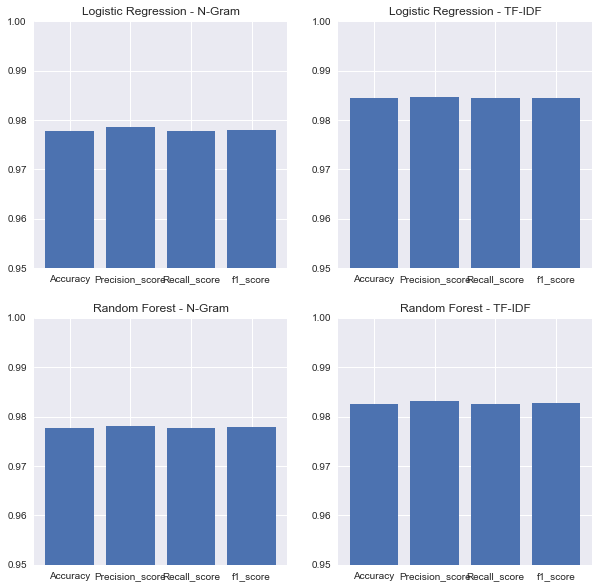

In [31]:
x_axis = ['Accuracy', 'Precision_score', 'Recall_score', 'f1_score']

plt.figure(1,figsize=(10,10))

plt.subplot(2,2,1)
plt.ylim([0.95, 1])
_ = plt.bar(x_axis, lr_ngram_results[1:])
plt.title('Logistic Regression - N-Gram')

plt.subplot(2,2,2)
plt.ylim([0.95, 1])
_ = plt.bar(x_axis, lr_tfidf_results[1:])
plt.title('Logistic Regression - TF-IDF')

plt.subplot(2,2,3)
plt.ylim([0.95, 1])
_ = plt.bar(x_axis, rf_ngram_results[1:])
plt.title('Random Forest - N-Gram')

plt.subplot(2,2,4)
plt.ylim([0.95, 1])
_ = plt.bar(x_axis, rf_tfidf_results[1:])
plt.title('Random Forest - TF-IDF')

In [32]:
d= {'Logistic Regression - N-Gram': lr_ngram_results[1:],
    'Logistic Regression - TF-IDF': lr_tfidf_results[1:],
    'Random Forest - N-Gram': rf_ngram_results[1:],
    'Random Forest - TF-IDF': rf_tfidf_results[1:]}
results = pd.DataFrame.from_dict(d)

results.set_axis(x_axis)

,Logistic Regression - N-Gram,Logistic Regression - TF-IDF,Random Forest - N-Gram,Random Forest - TF-IDF
Accuracy,0.977778,0.984541,0.977778,0.982609
Precision_score,0.978592,0.984582,0.978155,0.983131
Recall_score,0.977778,0.984541,0.977778,0.982609
f1_score,0.977942,0.984557,0.977878,0.982712


<div dir="rtl" style="text-align: right;">

הריצה שנתנה את התוצאה הטובה ביותר היא הריצה שבה השתמשנו במודל Logistic Regression ובפיצ'רים של TF-IDF.

הריצה קיבלה תוצאה גבוהה יותר משאר הריצות בכל הפרמטרים.
התוצאה הנוספת שהתקרבה אליה גם השתמשה ב-TF-IDF.
לכן ניתן להבין שהפיצ'רים האלה יותר משמעותיים ומביאים לתוצאות טובות יותר לעומת השיטה השנייה לחילוץ הפיצ'רים שהשתמשנו.

לדעתי, הסיבה שהפיצ'ר הזה יותר טוב הוא מכיוון שהוא מצרף את שכיחויות המילה לתהליך החיזוי ולא רק מידע של האם מילה נמצאת או לא נמצאת במייל.
האינפורמציה הנוספת הזו עוזרת לקבוע יותר טוב אם מייל הוא ספאם או לא.

לגבי המסווגים, הם הביאו ביצועים קרובים ויכול להיות שעם פרמטר אחר המסווג השני היה מקבל תוצאת חיזוי דומה.

</div>